# Сборный проект

# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Изучение данных из файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mt
from math import factorial
import seaborn as sns

In [2]:
df = pd.read_csv('/datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Итак после рассмотрения нашей таблицы мы видим следующий фронт работ:

1) Привести в нижнему регистру названия столбцов

2) Посмотреть что пропущено в названии игры и жанре, если это одни и те же строки то мы никак не сможем их идентифицировать, они могут оказаться дублем, и наверно правильным решением чтобы не портить анализ будет просто от них избавиться. 

3) Необходимо оценить заполнение данных с типом object (название, платформа, жанр, рейтинг), по возможности избавиться от пропусков;

4) Найти артефакты в столбце user_score и привести к типу float

5) Привести оценку критиков и пользователей к одной числовой разрядности и сделать столбец с общим (средним рейтингом)

6) Рассмотреть остальные пропуски 

7) Свести данные в столбец "продаж всего"

8) Избавиться от дубликатов

## Подготовка данных

In [5]:
df.set_axis(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'], axis = 'columns', inplace = True)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [6]:
df.query('name.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [7]:
df.query('platform == "GEN"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
145,Sonic the Hedgehog 2,GEN,1992.0,Platform,4.47,1.20,0.16,0.19,NaN,NaN,NaN
257,Sonic the Hedgehog,GEN,1991.0,Platform,3.03,0.91,0.26,0.13,NaN,NaN,NaN
564,Mortal Kombat,GEN,1992.0,Fighting,1.95,0.63,0.00,0.09,NaN,NaN,NaN
588,Streets of Rage,GEN,1990.0,Action,1.86,0.55,0.11,0.08,NaN,NaN,NaN
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
832,NBA Jam,GEN,1992.0,Sports,1.75,0.25,0.00,0.05,NaN,NaN,NaN
960,Sonic & Knuckles,GEN,1994.0,Platform,1.24,0.43,0.03,0.12,NaN,NaN,NaN
996,Sonic the Hedgehog 3,GEN,1994.0,Platform,1.02,0.47,0.20,0.07,NaN,NaN,NaN
1099,Street Fighter II': Special Champion Edition,GEN,1992.0,Fighting,1.00,0.30,0.31,0.04,NaN,NaN,NaN
1365,Disney's The Lion King,GEN,1994.0,Platform,0.97,0.37,0.03,0.05,NaN,NaN,NaN


In [8]:
df = df.drop(index = [659, 14244]).reset_index()
df = df.drop(['index'], axis = 1)

In [9]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [10]:
#df['name'].value_counts()
df.query('name == "Need for Speed: Most Wanted"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1189,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1590,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1997,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2047,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3580,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5971,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6272,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6409,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


После рассмотрения повторяющихся названий на примере НФС, мы видим что названия игр дублируются но у них имеется либо отличие по платформе, либо по году релиза. Поэтому по столбцу названий должно быть все корректно.

In [11]:
df['platform'].value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
GB        98
NES       98
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

Пропусков и дублей в столбце платформ нет. Платформы где всего несколько строк при необходимости можно будет фильтровать в дальнейшем. Смотрим дальше.

In [12]:
df['genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

С жанрами тоже все отлично.

In [13]:
df['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

Для понимания думаю стоит сделать отступление что обозначают данные аббревиатуры:

1) «E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет. Первоначально "K-A" ("Kids to Adults")

2) «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет.

3) «M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет.

4) «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать или немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови.

5) «EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. 

6) «RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга.

7) «AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое, а также сцены с обнажением.

Итак, при обработке этого столбца необходимо:

1) Переименовать "К-А" в "Е".

2) Значения 'RP' и 'АО', добавить к рейтингу 'M', поскольку этот рейтинг с большей вероятностью включает в себя все что может быть в играх, а значения 'EC' добавить к рейтингу 'E', поскольку врядли продукция для двухлетних и трехлетних значительно отличается.

3) Создать функцию для замены пропущенных значений, где пропущенные значения будут проставляться в зависимости от самого повторяющегося рейтинга по жанру.

In [14]:
df['rating'] = df['rating'].replace('K-A', 'E')
df['rating'] = df['rating'].replace('EC', 'E')
df['rating'] = df['rating'].replace('RP', 'M')
df['rating'] = df['rating'].replace('AO', 'M')
df['rating'].value_counts()

E       4001
T       2961
M       1567
E10+    1420
Name: rating, dtype: int64

Определим на какие значения будем производить замену при пропусках в разных жанрах.

In [15]:
df.pivot_table(index = 'genre', columns = 'rating', values = 'name', aggfunc = 'count')

rating,E,E10+,M,T
genre,,,,
Action,417.0,481.0,609.0,681.0
Adventure,164.0,68.0,99.0,115.0
Fighting,8.0,19.0,49.0,362.0
Misc,463.0,167.0,13.0,239.0
Platform,358.0,144.0,3.0,64.0
Puzzle,289.0,43.0,NaN,10.0
Racing,585.0,96.0,19.0,172.0
Role-Playing,84.0,111.0,162.0,420.0
Shooter,48.0,58.0,565.0,348.0


Из сводной таблицы видно следующее:

1) У файтингов, ролевых игр и стратегий большая часть возрастных ограничений соответсвует рейтингу "Т"

2) У головоломок, гонок и спорта подавляющее большинство составляет рейтинг "Е"

3) По остальным жанрам такой явной доминации не прослеживается, поэтому придется оставить у них пропущенные значения.

In [16]:
def change_rating(row):
    rating = row['rating']
    genre = row['genre']
    if rating == 'unknown' or rating == 'RP':
        if genre == 'Fighting' or genre == 'Role-Playing' or genre == 'Strategy':
            return('T')
    if rating == 'unknown' or rating == 'RP':
        if genre == 'Puzzle' or genre == 'Racing' or genre == 'Sports':
            return('E')
    return(rating)

In [17]:
df['rating'] = df['rating'].fillna('unknown')
df['rating'] = df.apply(change_rating, axis = 1)
df['rating'].value_counts()

E          5455
T          4437
unknown    3834
M          1567
E10+       1420
Name: rating, dtype: int64

Переходим к столбцу оценки пользователей.

In [18]:
df['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.3       2
1         2
1.5       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

А вот мы видим что превращает столбец с оценками в тип данных object. Аббревиатура 'tbd' обозначает to be determined - пока не определён. Давайте рассмотрим эту выборку подробнее.

In [19]:
df.query('user_score == "tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16693,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16695,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16696,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16702,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


Поскольку обозначение tbd - значит что рейтинг не определен, и у него нет каких то характерных особенностей по другим столбцам судя по срезу, то он ничем не отличается от пропущенных значений, превратим их также в NaN чтобы со столбцом можно было полноценно работать как с числовым.  

In [20]:
df['user_score'] = df['user_score'].replace('tbd', np.nan).astype(np.float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             16713 non-null object
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


Пропуски с оценками пользователей и критиков мы не сможем заменить, потому что у оценок нет привязки к консоли, году или жанру, хорошие и плохие игры могут быть везде. Однако мы можем привести оценки к одной разрядности, к примеру 10 бальной, для этого нужно значения в столбце с оценкой критиков разделить на 10. Также после этого мы можем сделать функцию для итоговой оценки: где есть только одна из оценок будет использоваться она, где оценки две - будет использоваться их среднее. Это поможет немного сократить кол-во игр без оценки без потери объективности, поскольку для продаж игры оба мнения важны одинаково.

In [21]:
df['critic_score'] = df['critic_score'] / 10
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,7.6,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,8.2,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,8.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,T


In [22]:
def total_score(row):
    critic_score = row['critic_score']
    user_score = row['user_score']
    if critic_score > 0 and user_score > 0:
        return((critic_score + user_score) / 2)
    if critic_score > 0:
        return(critic_score)
    if user_score > 0:
        return(user_score)
    return(np.nan)

In [23]:
df['total_score'] = df.apply(total_score, axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             16713 non-null object
total_score        8709 non-null float64
dtypes: float64(8), object(4)
memory usage: 1.5+ MB


Таким образом мы уменьшили число игр без оценки, хоть и немного. Далее остался последний столбец с пропусками который мы не рассматривали, это год издания.

In [24]:
df.query('year_of_release.isna()')['platform'].value_counts()

PS2     34
Wii     34
DS      30
X360    30
PS3     25
XB      21
2600    17
PC      17
PSP     16
GC      14
GBA     11
3DS      8
PS       7
N64      3
PSV      1
GB       1
Name: platform, dtype: int64

Поскольку пропущеные значения характеры разным играм, с разными жанрами и платформам, значит у природы этих пропусков проблема не связана этими параметрами. Могу предположить что это игры которые были переизданы со старой консоли на новую, потому что на более современных консолях больше игр без года издания, по причине того что более мощное железо дает больше возможностей для выхода ремастеров.

Поскольку для анализа данных нам потребуются даты выпуска игры, а мы не можем их определить, то поскольку в столбце с датой релиза у нас пропуски составляют менее 2% от общего количества, то проще всего просто удалить эти строки. 

In [25]:
df = df.dropna(axis='index', how='any', subset=['year_of_release'])
df['year_of_release'] = df['year_of_release'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16712
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             16444 non-null object
total_score        8551 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


Создадим столбец с итоговыми продажами и избавимся от дубликатов.

In [26]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_score,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,7.6,8.0,E,7.80,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,8.2,8.3,E,8.25,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,8.0,8.0,E,8.00,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,T,NaN,31.38


Давайте проверим дубликаты, в данном случае нас интересует чтобы не было одновременных повторений в столбцах name, platform, year_of_release, потому что если такие дубликаты будут, то нужно их суммировать или удалять.

In [27]:
df_test_duplicate = pd.DataFrame()
df_test_duplicate['name'] = df['name']
df_test_duplicate['platform'] = df['platform']
df_test_duplicate['year_of_release'] = df['year_of_release']
df_test_duplicate.duplicated().sort_values()

0        False
11126    False
11127    False
11128    False
11129    False
         ...  
5565     False
5566     False
5568     False
16712    False
16228     True
Length: 16444, dtype: bool

In [28]:
#df.loc[16228]
df.query('name == "Madden NFL 13"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_score,total_sales
507,Madden NFL 13,X360,2012,Sports,2.53,0.15,0.0,0.17,8.1,5.8,E,6.95,2.85
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,8.3,5.5,E,6.90,2.56
3985,Madden NFL 13,Wii,2012,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E,7.30,0.50
5886,Madden NFL 13,PSV,2012,Sports,0.28,0.00,0.0,0.02,6.3,7.3,E,6.80,0.30
7065,Madden NFL 13,WiiU,2012,Sports,0.21,0.00,0.0,0.02,7.5,6.7,E,7.10,0.23
16228,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,8.3,5.5,E,6.90,0.01


Мы нашли один дубль, необходимо суммировать значения и пересчитать итоговые продажи.

In [29]:
df.loc[604, 'eu_sales'] = 0.23
df = df.drop(index = [16228]).reset_index()
df = df.drop(['index'], axis = 1)
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

Мы закончили с подготовкой данных, пора браться за анализ.

## Исследовательский анализ данных

Давайте посмотрим сколько выпускалось игр по годам.

Text(0, 0.5, 'Количество игр')

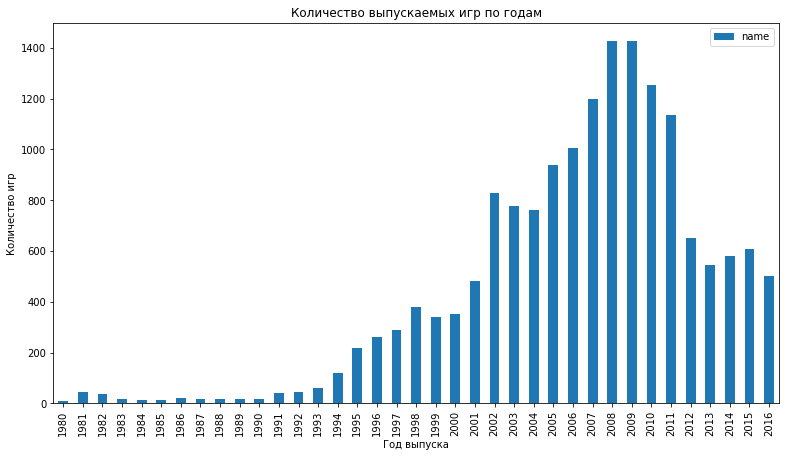

In [30]:
df.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count').plot(kind = 'bar', figsize = (13, 7))
plt.title('Количество выпускаемых игр по годам')
plt.xlabel("Год выпуска")
plt.ylabel("Количество игр")

Мы видим что начиная с 90-х начался активный рост количества выпускаемых игр в год, достигая своего пика в 2008 году, а далее пошло резкое снижение данного показателя, возможно это связано с более высокими требованиями по качеству которые появлялись с улучшением производительности компьютеров и консолей. Давайте посмотрим как выпускались игры по годам в разрезе различных платформ.

In [31]:
df['platform'].value_counts()

PS2     2127
DS      2121
PS3     1305
Wii     1286
X360    1232
PSP     1193
PS      1190
PC       957
GBA      811
XB       803
GC       542
3DS      512
PSV      429
PS4      392
N64      316
XOne     247
SNES     239
SAT      173
WiiU     147
2600     116
NES       98
GB        97
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

In [32]:
df_platform_years = df.pivot_table(index = 'year_of_release', columns = 'platform', values = 'name', aggfunc = 'count').reset_index()

Text(0, 0.5, 'Количество выпущенных игр')

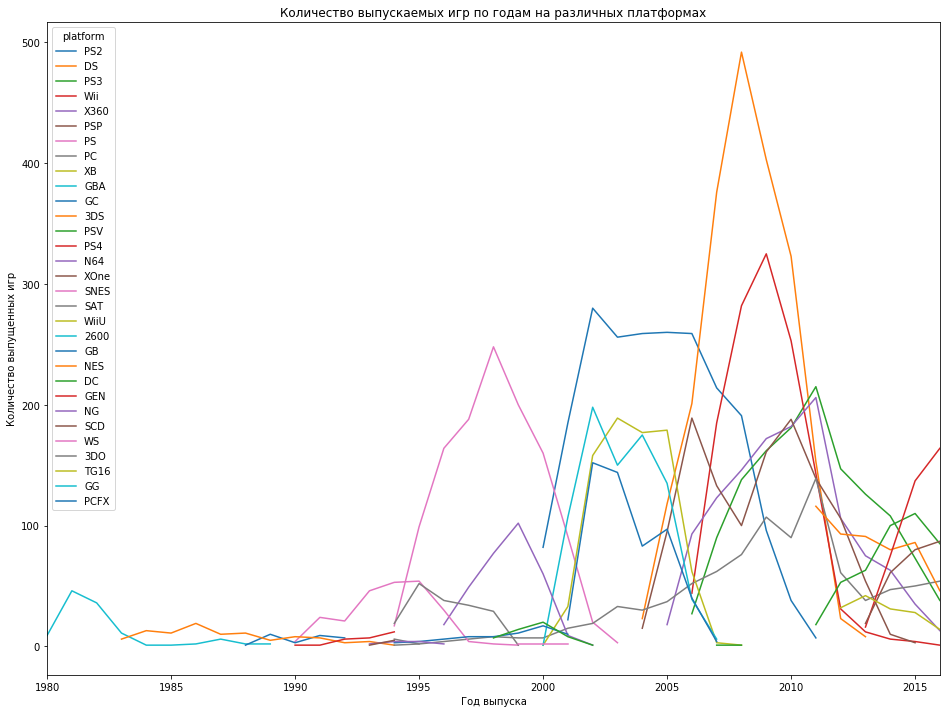

In [33]:
df_platform_years.plot(x="year_of_release", y=["PS2", "DS", "PS3", 'Wii', 'X360', 'PSP', 'PS', 'PC', 'XB', 'GBA', 'GC', '3DS', 'PSV', 'PS4', 'N64', 'XOne', 'SNES', 'SAT', 'WiiU', '2600', 'GB', 'NES', 'DC', 'GEN', 'NG', 'SCD', 'WS', '3DO', 'TG16', 'GG', 'PCFX'], figsize = (16, 12))
plt.title('Количество выпускаемых игр по годам на различных платформах')
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")

Исходя из графика мы видим что среднее время жизни игровой платформы (за исключением PC) около 10 лет. На основании этого мы можем сделать вывод что производить игры на старые платформы производителю не выгодно, а значит и заказывать игры старых платформ тоже невыгодно. Поскольку нас интересует чтобы игры продавались, давайте проверим этот вывод взяв более узкую выборку - платформы с самыми большими суммарными продажами и сколько лет на них выпускались игры.

In [34]:
df.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').reset_index().sort_values(by = 'total_sales', ascending = False).head(10)

,platform,total_sales
16,PS2,1233.56
28,X360,961.24
17,PS3,931.34
26,Wii,891.18
4,DS,802.78
15,PS,727.58
18,PS4,314.14
6,GBA,312.88
19,PSP,289.53
2,3DS,257.81


In [35]:
df_top_sales = df.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum').reset_index()

Text(0, 0.5, 'Количество игр')

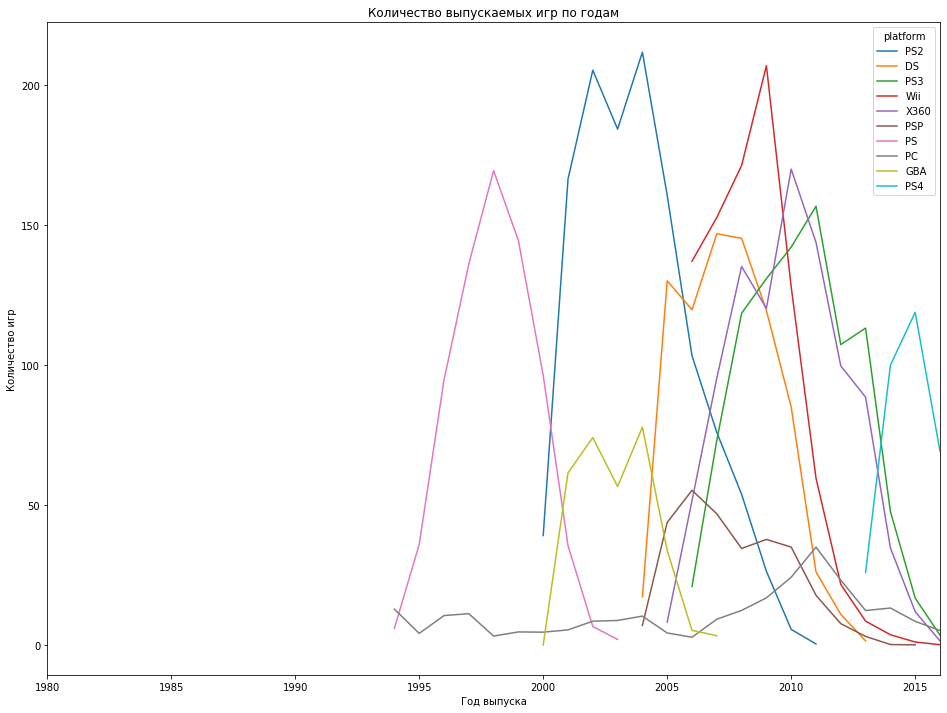

In [36]:
df_top_sales.plot(x="year_of_release", y=["PS2", "DS", "PS3", 'Wii', 'X360', 'PSP', 'PS', 'PC', 'GBA', 'PS4'], figsize = (16, 12))
plt.title('Количество выпускаемых игр по годам')
plt.xlabel("Год выпуска")
plt.ylabel("Количество игр")

На графике мы видим аналогичную картину, срок актуальности платформы в среднем около 10 лет, и дальше продажи по ней сменяются следующим поколением консоли, это наглядно видно на примере серии плейстейшн. Поэтому для определения игр для закупки на 2017 год необходимо убрать из анализа неактуальные платформы. Поскольку к концу периода жизни консоли выпускается меньше игр, можно посчитать неактуальный период все что больше 3 лет. Также учтем что судя по графику у нас не полные данные за 2016 год, возможно это связано что не все продажи внесены в таблицу или прошел не целый год. Поэтому сделаем выборку по играм 2013 года и младше.

In [37]:
df_fresh = df.query('year_of_release >= 2013')
df_fresh['platform'].value_counts()

PS4     392
PSV     358
PS3     345
3DS     303
XOne    247
PC      189
X360    186
WiiU    115
PSP      67
Wii      23
DS        8
Name: platform, dtype: int64

Text(0, 0.5, 'Количество игр')

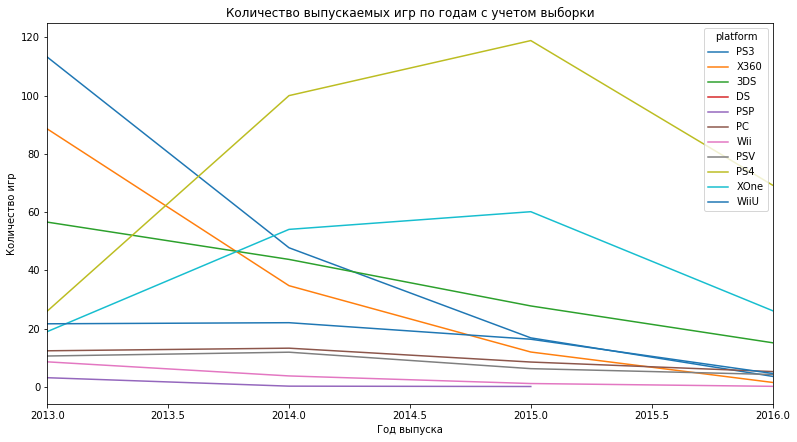

In [38]:
df_fresh_platform_years = df_fresh.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum').reset_index()
df_fresh_platform_years.plot(x="year_of_release", y=["PS3", "X360", "3DS", 'DS', 'PSP', 'PC', 'Wii', 'PSV', 'PS4', 'XOne', 'WiiU'], figsize = (13, 7))
plt.title('Количество выпускаемых игр по годам с учетом выборки')
plt.xlabel("Год выпуска")
plt.ylabel("Количество игр")

In [39]:
df_fresh['year_of_release'].value_counts()

2015    606
2014    581
2013    544
2016    502
Name: year_of_release, dtype: int64

Судя по этой выборке, есть недостоверный момент с тем что в 2016 году упало общее кол-во продаж, хотя до этого был стабильный рост. Могу предположить что данные по 16 году просто не актуализированы. Поэтому придется в своем анализе опираться на показатели продаж по 2015 год.

Если судить таким образом то у нас получаются два очевидных фаворита - единственные кто появился недавно и имеют хорошую положительную динамику - это PS4 и Xone.

Также мы видим относительно неплохие продажи по 3DS, их показатели падают пропорционально меньше чем у фаворитов, с учетом того что данные неактуализированы, поэтому можно предположить что они как минимум стабильно держатся на рынке и эту платформу из вида также не стоит.

Давайте рассмотрим диаграмму размаха по глобальным продажам игр с разбивкой по платформам.

Text(0, 0.5, 'Количество проданных игр в млн.')

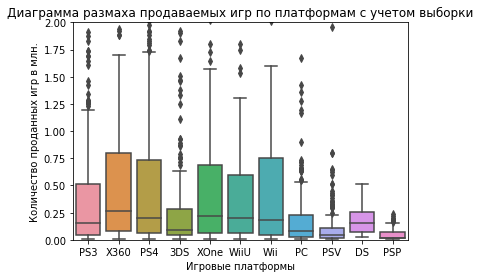

In [40]:
sns.boxplot(data = df_fresh , x = 'platform' , y = 'total_sales')
plt.ylim(0, 2)
plt.title('Диаграмма размаха продаваемых игр по платформам с учетом выборки')
plt.xlabel("Игровые платформы")
plt.ylabel("Количество проданных игр в млн.")

Text(0, 0.5, 'Количество проданных игр в млн.')

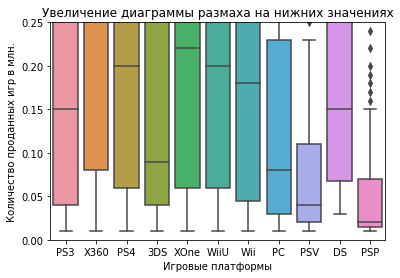

In [41]:
sns.boxplot(data = df_fresh , x = 'platform' , y = 'total_sales')
plt.ylim(0, 0.25)
plt.title('Увеличение диаграммы размаха на нижних значениях')
plt.xlabel("Игровые платформы")
plt.ylabel("Количество проданных игр в млн.")

На диаграмме размаха мы видим, что в границу нормального размаха входят с налучшими показателями X360, PS4 и Xone. Это в принципе подтверждает ранее сделанные выводы, а также стоит обратить внимание на 3DS, ранее мы видели что суммарные продажи по этой платформе довольно высоки, поэтому несмотря на то что медианные продажи игр этой платформы сильно уступают конкурентам, но отсутствие выбросов дает нам предположение что у этой платформы есть определенная фанатская база, которая стабильно делает хорошие продажи по большинству игр. Показатели по Wii, не совсем объективны так как ранее мы уже видели что в рассматриваемый период на консоли выходило на порядок меньше игр чем на других, но можем для себя отметить это как показатель качества.

Давайте посмотрим как влияют отзывы критиков и пользователей на продажи, на примере одной платформы с наибольшим количеством отзывов.

In [42]:
df_choose_platform = df_fresh.pivot_table(index = 'platform', values = ['name', 'critic_score', 'user_score', 'total_score'], aggfunc = 'count').reset_index()
df_choose_platform['koef'] = df_choose_platform['total_score'] / df_choose_platform['name']
df_choose_platform.sort_values(by = 'koef', ascending = False).head(5)

,platform,critic_score,name,total_score,user_score,koef
2,PC,149,189,156,155,0.825397
9,X360,81,186,143,143,0.768817
10,XOne,169,247,186,182,0.753036
8,WiiU,70,115,81,80,0.704348
4,PS4,252,392,260,257,0.663265


In [43]:
df_pc = df_fresh.query('platform == "PC"')
df_corr_pc = pd.DataFrame()
df_corr_pc['total_sales'] = df_pc['total_sales']
df_corr_pc['critic_score'] = df_pc['critic_score']
df_corr_pc['user_score'] = df_pc['user_score']
df_corr_pc['total_score'] = df_pc['total_score']
df_corr_pc.corr()['total_sales']

total_sales     1.000000
critic_score    0.196030
user_score     -0.093842
total_score     0.032334
Name: total_sales, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2cba142210>,
      dtype=object)

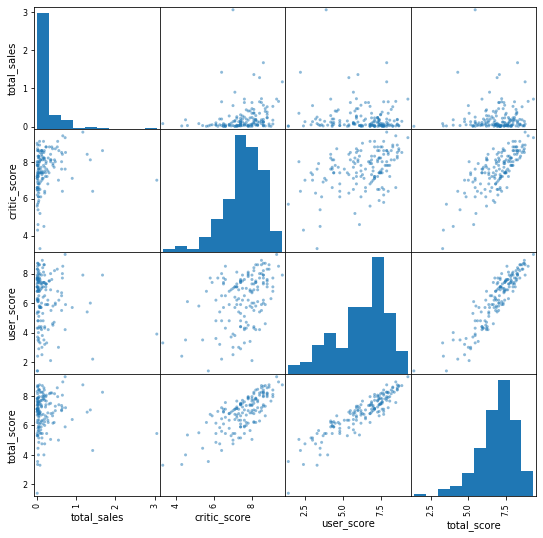

In [44]:
pd.plotting.scatter_matrix(df_corr_pc, figsize=(9, 9))

Исходя из корреляции и диаграммы рассеяния, мы видим что у продаж слабо выраженная, но положительная корреляция с оценками критиков, а значит что при выборе игр на продажу имеет смысл ориентироваться на отзывы критиков, они влияют на мнение потенциальных покупателей, но не критично. 

При этом корреляция продаж с оценками пользователей вообще не влияет на продажи, показатель около 0.

А теперь давайте посмотрим справедливо ли это для других платформ.

Text(0, 0.5, 'Суммарные продажи')

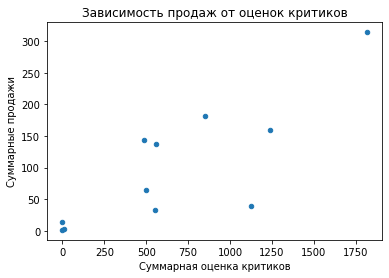

In [45]:
df_fresh.pivot_table(index = 'platform', values = ['user_score', 'critic_score', 'total_sales'], aggfunc = 'sum').reset_index().plot(x="critic_score", y="total_sales", kind="scatter")
plt.title('Зависимость продаж от оценок критиков')
plt.xlabel("Суммарная оценка критиков")
plt.ylabel("Суммарные продажи")

В общем и целом закономерность прослеживается, чем больше оценок от критиков и чем они выше у игр на тех или иных консолях, тем лучше они продаются.

А теперь давайте посмотрим как жанр влияет на продажи игры.

Text(0, 0.5, 'Медиана по продажам (в млн. копий)')

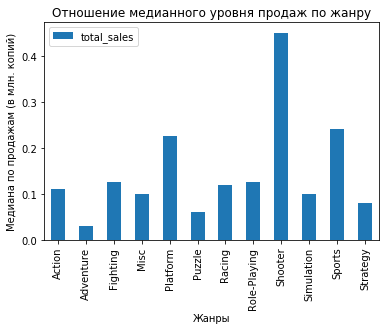

In [46]:
df_fresh.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'median').reset_index().plot(x = "genre", y = "total_sales", kind = 'bar')
plt.title('Отношение медианного уровня продаж по жанру')
plt.xlabel("Жанры")
plt.ylabel("Медиана по продажам (в млн. копий)")

Text(0, 0.5, 'Среднее по продажам (в млн. копий)')

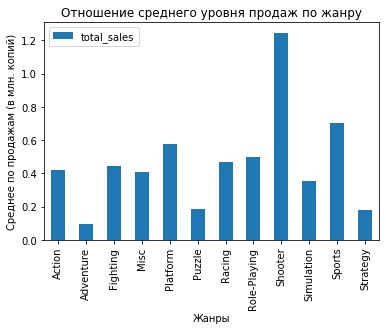

In [47]:
df_fresh.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'mean').reset_index().plot(x = "genre", y = "total_sales", kind = 'bar')
plt.title('Отношение среднего уровня продаж по жанру')
plt.xlabel("Жанры")
plt.ylabel("Среднее по продажам (в млн. копий)")

Судя по показателям самый продаваемый жанр в мире это жанр шутеры, следом за ним идут спорт и платформеры. 

Также на этом графике мы видим что самые плохо продаваемые игры по миру это приключения, стратегии и головоломки. 

Ну что поделать, видимо покупателям хватает интеллектуальной активности в реальной жизни, а в играх хочется получить эмоциональную разгрузку и кого нибудь расстрелять. Мы это уважаем и обязательно учтем при выборе игр для закупки на 2017 год.

### Вывод:

Благодаря нашему анализу мы выяснили:

1) Что консоли имеют свой срок жизни, в среднем в пределах 10 лет и для лучших продаж желательно выбирать более свежие консоли, в нашем случае это PS4, Xone и WiiU.

2) Что продажи имеют определенную зависимость от оценки критиков, и чем выше оценки и чем их больше, тем с большей вероятностью игра покажет хорошие продажи.

3) Также мы выделили самые популярные жанры среди покупателей.

Эти выводы уже могут сильно облегчить выбор игр для продажи, но давайте проверим одинаково ли ведут себя покупатели в разных регионах. 

## Составление портретов пользователей в разных регионах
Давайте оценим продажи по платформам в разных регионах и определим топ 5 по каждому.

Text(0, 0.5, 'Продажи (в млн. копий)')

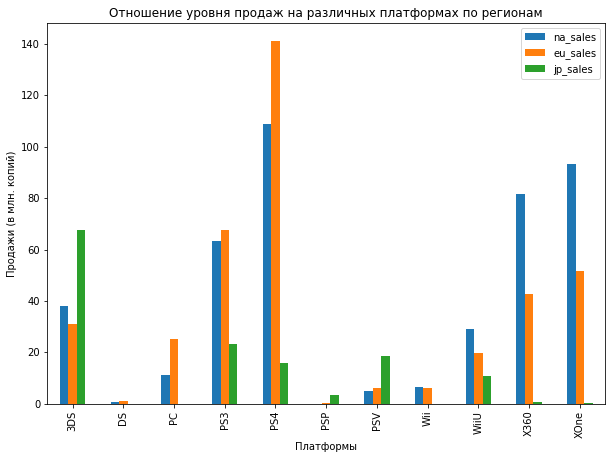

In [48]:
df_top_5_platform_in_region = df_fresh.pivot_table(index = 'platform', values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')
df_top_5_platform_in_region.reset_index().plot(kind = 'bar', x = 'platform', y = ['na_sales', 'eu_sales', 'jp_sales'], figsize = (10, 7))
plt.title('Отношение уровня продаж на различных платформах по регионам')
plt.xlabel("Платформы")
plt.ylabel("Продажи (в млн. копий)")

In [49]:
# Северная Америка
df_top_5_platform_in_region['na_sales'].sort_values(ascending = False).head()

platform
PS4     108.74
XOne     93.12
X360     81.66
PS3      63.50
3DS      38.20
Name: na_sales, dtype: float64

In [50]:
# Европа
df_top_5_platform_in_region['eu_sales'].sort_values(ascending = False).head()

platform
PS4     141.09
PS3      67.81
XOne     51.59
X360     42.52
3DS      30.96
Name: eu_sales, dtype: float64

In [51]:
# Япония
df_top_5_platform_in_region['jp_sales'].sort_values(ascending = False).head()

platform
3DS     67.81
PS3     23.35
PSV     18.59
PS4     15.96
WiiU    10.88
Name: jp_sales, dtype: float64

На графике мы видим следующее: 

1) Продажи в Японии значительно ниже чем в Америке и Европе, вероятно потому что сам регион по размерам значительно меньше.

2) Из особенностей Японских продаж мы видим что японские покупатели почти полностью игнорируют игры на PC и линейку xbox. Предположу что это происходит из-за поддержки отечественного производителя (Сони и Нинтендо) со стороны правительства.

3) Также японцы отличаются тем что предпочитают портативные консоли, несмотря на более низкие продажи в целом, они лидеры по продажам платформ которые всегда можно носить с собой.

4) Европа и Америка в целом схожи по предпочтениям, и у них происходят хорошие продажи игр на домашние консоли.

5) Из отличий по предпочтениям европейцев и американцев можно выделить что в америке лучше всего продаются игры на xbox, а в европе на линейку Сони и ПК.

Text(0, 0.5, 'Продажи (в млн. копий)')

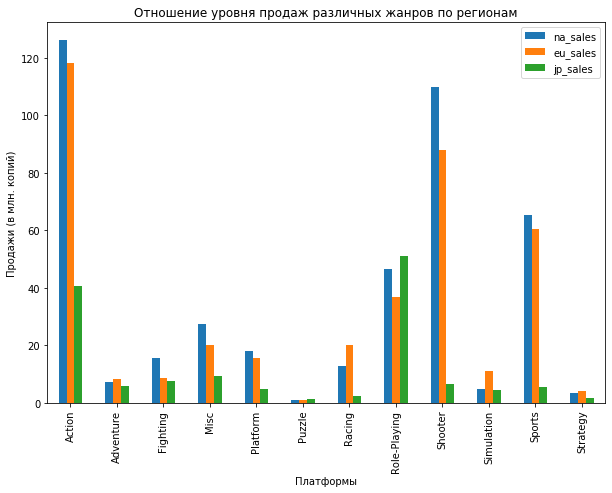

In [52]:
df_top_5_genre_in_region = df_fresh.pivot_table(index = 'genre', values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')
df_top_5_genre_in_region.reset_index().plot(kind = 'bar', x = 'genre', y = ['na_sales', 'eu_sales', 'jp_sales'], figsize = (10, 7))
plt.title('Отношение уровня продаж различных жанров по регионам')
plt.xlabel("Платформы")
plt.ylabel("Продажи (в млн. копий)")

При анализе графика продаж в регионах в зависимости от жанра игр, мы можем сделать следующие выводы:

1) Можно уверенно сказать что любимый жанр игр у японцев - это РПГ.

2) Американцы и Европейцы и тут демонстрируют схожие вкусы, единственное на что можно обратить внимание - это то что европейцы покупают больше игр про гонки, по остальным жанрам пропорции по продажам в среднем соблюдаются.

3) Ранее мы отмечали что шутеры занимают первое место по популярности, однако Япония в этом вопросе исключение из правил и при закупках это также нужно учитывать. Хотя проблема может быть в том, что на портативных консолях просто нет хорошего выбора шутеров или в которые было бы удобно играть с маленьким экраном. 

Text(0, 0.5, 'Продажи (в млн. копий)')

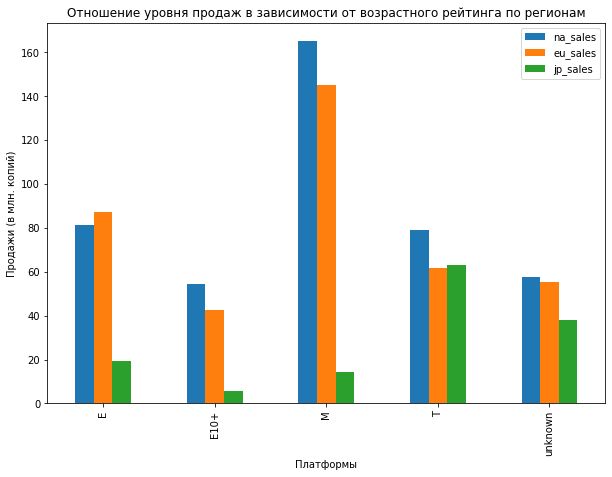

In [53]:
df_top_5_rating_in_region = df_fresh.pivot_table(index = 'rating', values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')
df_top_5_rating_in_region.reset_index().plot(kind = 'bar', x = 'rating', y = ['na_sales', 'eu_sales', 'jp_sales'], figsize = (10, 7))
plt.title('Отношение уровня продаж в зависимости от возрастного рейтинга по регионам')
plt.xlabel("Платформы")
plt.ylabel("Продажи (в млн. копий)")

По возрастному рейтингу мы видим что в общем тенденция по регионам почти одинаковая, выбивается из общего вида снова только Япония. В Японии самый популярный возрастной рейтинг - это 'T', и сравнительно очень низкие показатели у рейтинга 'M'. Это объяснимо тем что в Японии есть определенные культурные особенности в плане работы, работа у взрослых японцев отнимает много времени и времени на сил и игры у них просто не остается, поэтому можно предположить что целевая аудитория в Японии это подростки. Второй вариант возникновения таких особенностей может скрываться в том что в Японии могут быть дополнительные ограничения на продажи игр с высоким возрастным рейтингом со стороны правительства, которое борется с жестокими играми. 

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
Примем за нулевую гипотезу что средние рейтинги платформ XboxOne и PC одинаковы, в противном случае при отказе от нулевой гипотезы будем предполагать что верна обратная гипотеза - что рейтинги различаются.

In [54]:
df_score_xone = df_fresh.query('platform == "XOne"')
df_score_pc = df_fresh.query('platform == "PC"')
df_user_score_xone = df_score_xone['user_score'].dropna()
df_user_score_pc = df_score_pc['user_score'].dropna()

In [55]:
sigma_score_xone = np.std(df_user_score_xone, ddof = 1)
dispersion_score_xone = sigma_score_xone ** 2
dispersion_score_xone

1.9069968429360693

In [56]:
sigma_score_pc = np.std(df_user_score_pc, ddof = 1)
dispersion_score_pc = sigma_score_pc ** 2
dispersion_score_pc

3.0358927524088815

In [57]:
# Среднее по xbox
df_user_score_xone.mean()

6.521428571428572

In [58]:
# Среднее по ПК
df_user_score_pc.mean()

6.2696774193548395

In [59]:
alpha = 0.05
result_first = st.ttest_ind(df_user_score_xone, df_user_score_pc, equal_var = False)
result_first.pvalue

0.14759594013430463

In [60]:
if (result_first.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


Полученные значения среднего говорит о том, что вероятность равных средних рейтингов у XBox One и PC, совсем не маленькая. И на основании ттеста мы скорее можем предположить, что рейтинги игр на этих платформах близки по значению, возможно что в большинстве своем это одни и те же игры. Так что есть вероятность что наша изначальная гипотеза верна.

### Средние пользовательские рейтинги жанров Action и Sports разные.
Примем за нулевую гипотезу что средние пользовательские рейтинги жанров Action и Sports одинаковы, в противном случае при отказе от нулевой гипотезы будем предполагать что верна обратная гипотеза - что рейтинги различаются.

In [61]:
df_score_action = df_fresh.query('genre == "Action"')
df_score_sports = df_fresh.query('genre == "Sports"')
df_user_score_action = df_score_action['user_score'].dropna()
df_user_score_sports = df_score_sports['user_score'].dropna()

In [62]:
sigma_score_action = np.std(df_user_score_action, ddof = 1)
dispersion_score_action = sigma_score_action ** 2
dispersion_score_action

1.7693609042482703

In [63]:
sigma_score_sports = np.std(df_user_score_sports, ddof = 1)
dispersion_score_sports = sigma_score_sports ** 2
dispersion_score_sports

3.180612814465409

In [64]:
# Среднее Экшен
df_user_score_action.mean()

6.837532133676092

In [65]:
# Среднее Спорт
df_user_score_sports.mean()

5.238124999999999

In [66]:
alpha = 0.05
result_second = st.ttest_ind(df_user_score_action, df_user_score_sports, equal_var = False)
result_second.pvalue

1.4460039700704315e-20

In [67]:
if (result_second.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


Полученное значение pvalue говорит о том, что рейтинг игр этих двух жанров, с высокой вероятностью отличается. Мы уверенно можем отвергнуть мысль о том что что их пользовательские рейтинги равны. А значит пока мы можем продолжать считать что средние пользовательские рейтинги жанров Action и Sports разные.

## Вывод по проекту

По итогам проведенной исследовательской работы, мы вывели целый ряд рекомендаций на которые нужно будет обращать внимание при закупке на 2017 год:

1) Необходимо отдавать приоритетное значение играм на платформах XBox One и PS4, они должны показать самые высокие продажи в 2017 году. 

2) При выборе игр нужно обращать внимание на отзывы критиков, хорошо освещаемую игру лучше покупают.

3) Нужно закупать больше игр популярных жанров, в Америке и Европе это Шутеры и Спорт, а в Японии РПГ и Экшен.

4) При работе с Японским регионом нужно отдавать приоритет играм на портативные консоли, а в Америке и Европе на стационарные платформы.

5) Нужно быть аккуратным при продажах в Японии игр с рейтинговыми ограничениями 17+.

6) Высока вероятность что игры линейки платформ XBox в Японии не продадутся.

7) Нужно учитывать что в Европе предпочитают Сони а в Америке XBox

8) Ну и последнее, стоит отметить что поскольку рейтинги пользователей между PC и Xbox One с высокой вероятностью равны, можно предположить что речь идет об одинаковых играх, и это как раз причина по которой Xbox проигрывает Сони в Европе, какая то часть пользователей предпочитает играть эти же игры на своем ПК, и если эта гипотеза окажется верна, то имеет смысл продавать в Европе больше игр на PC чем в других регионах, особенно которые также выходят на XBox.